In [237]:
import numpy as np
from pathlib import Path
from utils import project_root
import os
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial.transform import Rotation

%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,12)

# Helpers

In [238]:
rot_order = 'xyz'

In [239]:
# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# Load data

In [240]:
os.chdir(Path(project_root() / 'data/topics/validation/VTE_2022-06-10-13-43-04'))
# os.chdir(Path(project_root() / 'data/topics/validation/VTE_2022-06-10-13-38-17'))

## Number of radar returns

In [241]:
# load ROS data from txt file
lines = []
with open('few_pts.txt') as f:
    lines = f.readlines()

    num_pts = []
    sec_pts = []
    nsec_pts = []
    count = 0
    for line in lines:
        count += 1
        if line[0:4] == "sec:":
            t = int(line[5:-1])
            sec_pts.append(t)
        elif line[0:5] == "nsec:":
            nsec_pts.append(int(line[6:-1]))
        elif line[0] == "#":
            num_pts.append(float(line[13:-1]))

temp = [i*1e-9 for i in nsec_pts]
t_pts = [sum(x) for x in zip(sec_pts, temp)]
tt_pts = np.array([x-t_pts[0] for x in t_pts])

num_pts = np.array(num_pts)

In [242]:
# load ROS data from txt file
lines = []
with open('few_inliers.txt') as f:
    lines = f.readlines()

    num_pts_incl_inliers = []
    num_inliers = []
    sec_inliers = []
    nsec_inliers = []
    count = 0
    for line in lines:
        count += 1
        if line[0:4] == "sec:":
            t = int(line[5:-1])
            sec_inliers.append(t)
        elif line[0:5] == "nsec:":
            nsec_inliers.append(int(line[6:-1]))
        elif line[0:12] == "# of points:":
            num_pts_incl_inliers.append(float(line[13:-1]))
        elif line[0:13] == "# of inliers:":
            num_inliers.append(float(line[14:-1]))

temp = [i*1e-9 for i in nsec_inliers]
t_inliers = [sum(x) for x in zip(sec_inliers, temp)]
tt_inliers = np.array([x-t_pts[0] for x in t_inliers])

num_pts_incl_inliers = np.array(num_pts_incl_inliers)
num_inliers = np.array(num_inliers)

In [243]:
print(len(num_pts), len(num_pts_incl_inliers), len(num_inliers))

446 804 804


## GPS position - ground truth

In [244]:
# load ROS data from txt file
lines = []
with open('gps_position.txt') as f:
    lines = f.readlines()

    x_gps = []
    y_gps = []
    sec_gps = []
    nsec_gps = []
    count = 0
    for line in lines:
        count += 1
        if line[4:8] == "sec:":
            t = int(line[9:-1])
            sec_gps.append(t)
        elif line[4:12] == "nanosec:":
            nsec_gps.append(int(line[13:-1]))
        elif line[0:2] == "x:":
            x_gps.append(float(line[2:-1]))
        elif line[0:2] == "y:":
            y_gps.append(float(line[2:-1]))

temp = [i*1e-9 for i in nsec_gps]
t_gps_pos = [sum(x) for x in zip(sec_gps, temp)]
tt_gps_pos = np.array([x-t_gps_pos[0] for x in t_gps_pos])

x_gps = np.array(x_gps)
y_gps = np.array(y_gps)
gps_pos = np.stack((x_gps, y_gps), 1)

In [245]:
print(len(tt_gps_pos), gps_pos.shape)

1396 (1396, 2)


## GPS (fault) position

In [246]:
# # load ROS data from txt file
# lines = []
# with open('gps_positionf.txt') as f:
#     lines = f.readlines()

#     x_gpsf = []
#     y_gpsf = []
#     sec_gps = []
#     nsec_gps = []
#     count = 0
#     for line in lines:
#         count += 1
#         if line[4:8] == "sec:":
#             t = int(line[9:-1])
#             sec_gps.append(t)
#         elif line[4:12] == "nanosec:":
#             nsec_gps.append(int(line[13:-1]))
#         elif line[0:2] == "x:":
#             x_gpsf.append(float(line[2:-1]))
#         elif line[0:2] == "y:":
#             y_gpsf.append(float(line[2:-1]))

# temp = [i*1e-9 for i in nsec_gps]
# t_gps_posf = [sum(x) for x in zip(sec_gps, temp)]
# tt_gps_posf = np.array([x-t_gps_pos[0] for x in t_gps_posf])

# x_gpsf = np.array(x_gpsf)
# y_gpsf = np.array(y_gpsf)
# gps_posf = np.stack((x_gpsf, y_gpsf), 1)

In [247]:
# print(len(tt_gps_posf), gps_posf.shape)

## GPS velocity - from position differentiation

In [248]:
# extract linear velocities from differentiating gps positions
dx_gps = []
dy_gps = []
for i in range(len(t_gps_pos)):
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        vx, vy = 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = t_gps_pos[i] - t_gps_pos[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
        vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt

    dx_gps.append(vx)
    dy_gps.append(vy)

dx_gps = np.array(dx_gps)
dy_gps = np.array(dy_gps)
gps_dp = np.stack((dx_gps, dy_gps), 1)

In [249]:
print(len(t_gps_pos), gps_dp.shape)

1396 (1396, 2)


## GPS heading - ground truth

In [250]:
# load ROS data from txt file
lines = []
flag = None
with open('gps_heading.txt') as f:
    lines = f.readlines()

    yaw = []
    sec_yaw = []
    nsec_yaw = []
    for line in lines:
        # find what we are saving
        if line[4:7] == "sec":
            sec_yaw.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_yaw.append(int(line[13:-1]))
        elif line[0:8] == "heading:":
            yaw.append(float(line[9:-1]))

temp = [i*1e-9 for i in nsec_yaw]
t_gps_heading = [sum(x) for x in zip(sec_yaw, temp)]
tt_gps_heading = np.array([x-t_gps_heading[0] for x in t_gps_heading])

gps_heading = np.array(yaw)

In [251]:
print(len(tt_gps_heading), len(gps_heading))

1298 1298


## GPS velocity ground truth

In [252]:
# load ROS data from txt file
lines = []
with open('gps_twist.txt') as f:
    lines = f.readlines()

    vx_gps = []
    vy_gps = []
    wz_gps = []
    sec_gps = []
    nsec_gps = []
    count = 0
    for line in lines:
        count += 1
        if line[4:8] == "sec:":
            t = int(line[9:-1])
            sec_gps.append(t)
        elif line[4:12] == "nanosec:":
            nsec_gps.append(int(line[13:-1]))
            
        if line[2:9] == "linear:":
            flag = "linear"
        elif line[2:10] == "angular:":
            flag = "angular"
            
        if flag == "linear":
            if line[4:6] == "x:":
                vx_gps.append(float(line[7:-1]))
            elif line[4:6] == "y:":
                vy_gps.append(float(line[7:-1]))
        
        if flag == "angular":
            if line[4:6] == "z:":
                wz_gps.append(float(line[7:-1]))

temp = [i*1e-9 for i in nsec_gps]
t_gps_twist = [sum(x) for x in zip(sec_gps, temp)]
tt_gps_twist = np.array([x-t_gps_twist[0] for x in t_gps_twist])

vx_gps = np.array(vx_gps)
vy_gps = np.array(vy_gps)
wz_gps = np.array(wz_gps)

In [253]:
print(len(tt_gps_twist), len(vx_gps), len(vy_gps), len(wz_gps))

1298 1298 1298 1298


## Radar Odom data

In [254]:
# load ROS data from txt file
lines = []
with open('ro.txt') as f:
    lines = f.readlines()

    n = []
    v = []
    w = []
    lsq_ssr = []
    ransac_ssr = []
    sec = []
    nsec = []
    for line in lines:        
        # find what we are saving
        if line[4:7] == "sec":
            t = int(line[9:-1])
            if sec and t < sec[-1]:
                print("WTF", t)
            sec.append(t)
        elif line[4:11] == "nanosec":
            nsec.append(int(line[13:-1]))
        elif line[0:10] == "num_points":
            n.append(int(line[12:-1]))
        elif line[0:16] == "heading_velocity":
            v.append(float(line[18:-1]))
        elif line[0:8] == "yaw_rate":
            w.append(float(line[10:-1]))
        elif line[0:10] == "ransac_ssr":
            ransac_ssr.append(float(line[12:-1]))
        elif line[0:7] == "lsq_ssr":
            lsq_ssr.append(float(line[9:-1]))
                
temp = [i*1e-9 for i in nsec]
t_ro = [sum(x) for x in zip(sec, temp)]
tt_ro = np.array([x-t_ro[0] for x in t_ro])

num_pts_ro = np.array(n, dtype=object)
v_ro = np.array(v, dtype=object)
w_ro = np.array(w, dtype=object)
# r_ro = np.array(R, dtype=object)
ransac_ssr_ro = np.array(ransac_ssr, dtype=object)
lsq_ssr_ro = np.array(lsq_ssr, dtype=object)

In [255]:
print(len(tt_ro), len(v_ro), len(w_ro), len(ransac_ssr_ro), len(lsq_ssr_ro))

1227 1227 1227 1227 1227


## Radar-IMU state

In [256]:
# load ROS data from txt file
lines = []
flag = None
with open('state_ri.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state2 = [sum(x) for x in zip(sec_state, temp)]
tt_state2 = np.array([x-t_state2[0] for x in t_state2])

p2 = np.array(p, dtype=object)
v2 = np.array(v, dtype=object)
q2 = np.array(q, dtype=object)

In [257]:
print(len(tt_state2), len(p2), len(v2), len(q2))

14189 14189 14189 14189


## GPS-IMU state

In [258]:
# load ROS data from txt file
lines = []
flag = None
with open('state_gi.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state1 = [sum(x) for x in zip(sec_state, temp)]
tt_state1 = np.array([x-t_state1[0] for x in t_state1])

p1 = np.array(p, dtype=object)
v1 = np.array(v, dtype=object)
q1 = np.array(q, dtype=object)

In [259]:
print(len(tt_state1), len(p1), len(v1), len(q1))

13289 13289 13289 13289


## GPS-IMU-Radar state

In [260]:
# load ROS data from txt file
lines = []
flag = None
with open('state_gri.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state0 = [sum(x) for x in zip(sec_state, temp)]
tt_state0 = np.array([x-t_state0[0] for x in t_state0])

p0 = np.array(p, dtype=object)
v0 = np.array(v, dtype=object)
q0 = np.array(q, dtype=object)

In [261]:
print(len(tt_state0), len(p0), len(v0), len(q0))

15943 15943 15943 15943


## GPS - IMU - Radar - RTK

In [262]:
# load ROS data from txt file
lines = []
flag = None
with open('state_ori.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state_ori = [sum(x) for x in zip(sec_state, temp)]
tt_state_ori = np.array([x-t_state_ori[0] for x in t_state_ori])

pori = np.array(p, dtype=object)
vori = np.array(v, dtype=object)
qori = np.array(q, dtype=object)

In [263]:
print(len(tt_state_ori), len(pori), len(vori), len(qori))

15021 15021 15021 15021


## GPS(loss)-IMU-Radar state

In [264]:
# load ROS data from txt file
lines = []
flag = None
with open('state_l.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_statel = [sum(x) for x in zip(sec_state, temp)]
tt_statel = np.array([x-t_statel[0] for x in t_statel])

pl = np.array(p, dtype=object)
vl = np.array(v, dtype=object)
ql = np.array(q, dtype=object)

In [265]:
print(len(tt_statel), len(pl), len(vl), len(ql))

15451 15451 15451 15451


## GPS(fault)-IMU-Radar state

In [266]:
# # load ROS data from txt file
# lines = []
# flag = None
# with open('state_f.txt') as f:
#     lines = f.readlines()

#     p = []
#     pi = -1
#     v = []
#     vi = -1
#     q = []
#     qi = -1
#     sec_state = []
#     nsec_state = []
#     for line in lines:
#         # break at ".nan" and pop the empty list(s) that were just appended
# #         if line[5:-1] == ".nan":
# #             sec_state.pop()
# #             nsec_state.pop()
# #             if flag == 'p':
# #                 p.pop()
# #             elif flag == 'v':
# #                 p.pop()
# #                 v.pop()
# #             elif flag == 'q':
# #                 p.pop()
# #                 v.pop()
# #                 q.pop()
# #             break
        
#         # find what we are saving
#         if line[4:7] == "sec":
#             sec_state.append(int(line[9:-1]))
#         elif line[4:11] == "nanosec":
#             nsec_state.append(int(line[13:-1]))
# #         elif line[12:15] == "GPS":
# #             sec_state[-1] = sec_state[-2]
# #             nsec_state[-1] = nsec_state[-2] 
# #         elif line[12:15] == "Rad":
# #             sec_state[-1] = sec_state[-2]
# #             nsec_state[-1] = nsec_state[-2]
#         elif line[0:2] == "p:":
#             p.append([])
#             flag = 'p'
#             pi += 1
#         elif line[0:2] == "v:":
#             v.append([])
#             vi += 1
#             flag = 'v'
#         elif line[0:2] == "q:":
#             q.append([])
#             qi += 1
#             flag = 'q'
        
#         # save to the corresponding list
#         if flag == 'p':
#             if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
#                 p[pi].append(float(line[5:-1]))
#         elif flag == 'v':
#             if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
#                 v[pi].append(float(line[5:-1]))
#         elif flag == 'q':
#             if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
#                 q[qi].append(float(line[5:-1]))
#                 if line[2:4] == "w:":
#                     flag = None

# temp = [i*1e-9 for i in nsec_state]
# t_statef = [sum(x) for x in zip(sec_state, temp)]
# tt_statef = tt_from_t(t_statef)

# pf = np.array(p, dtype=object)
# vf = np.array(v, dtype=object)
# qf = np.array(q, dtype=object)

In [267]:
# print(len(tt_statel), len(pl), len(vl), len(ql))

## GPS(loss) - IMU - Radar - RTK

In [268]:
# load ROS data from txt file
lines = []
flag = None
with open('state_ori_l.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_stateall = [sum(x) for x in zip(sec_state, temp)]
tt_stateall = np.array([x-t_stateall[0] for x in t_stateall])

pall = np.array(p, dtype=object)
vall = np.array(v, dtype=object)
qall = np.array(q, dtype=object)

In [269]:
print(len(tt_stateall), len(pall), len(vall), len(qall))

16129 16129 16129 16129


# Visualize

## Radar Odom results

### Extract residuals

In [270]:
gps_heading_vel = np.sqrt(vx_gps**2 + vy_gps**2)
gps_hv = np.sqrt(gps_dp[:,0]**2 + gps_dp[:,1]**2)

In [271]:
# function to return the index of the closest reading to the given timestamp
def get_close_reading(time, times):
    min_dt = 10000
    for idx, stamp in enumerate(times):
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

In [272]:
vel_resids = []
v_res = []
for i in range(len(v_ro)):
    # get closest radar odom reading
    e, idx = get_close_reading(t_ro[i], t_gps_twist)
    vel_resids.append(gps_heading_vel[idx]- v_ro[i])
    
    e, idx = get_close_reading(t_ro[i], t_gps_pos)
    v_res.append(gps_hv[idx]- v_ro[i])

print("Mean difference between GPS twist and Radar heading velocity: ", np.mean(vel_resids), "m/sec")
print("Mean difference between GPS dp/dt and Radar heading velocity: ", np.mean(v_res), "m/sec")

Mean difference between GPS twist and Radar heading velocity:  0.01745557472670439 m/sec
Mean difference between GPS dp/dt and Radar heading velocity:  0.05785262970465333 m/sec


### Plots

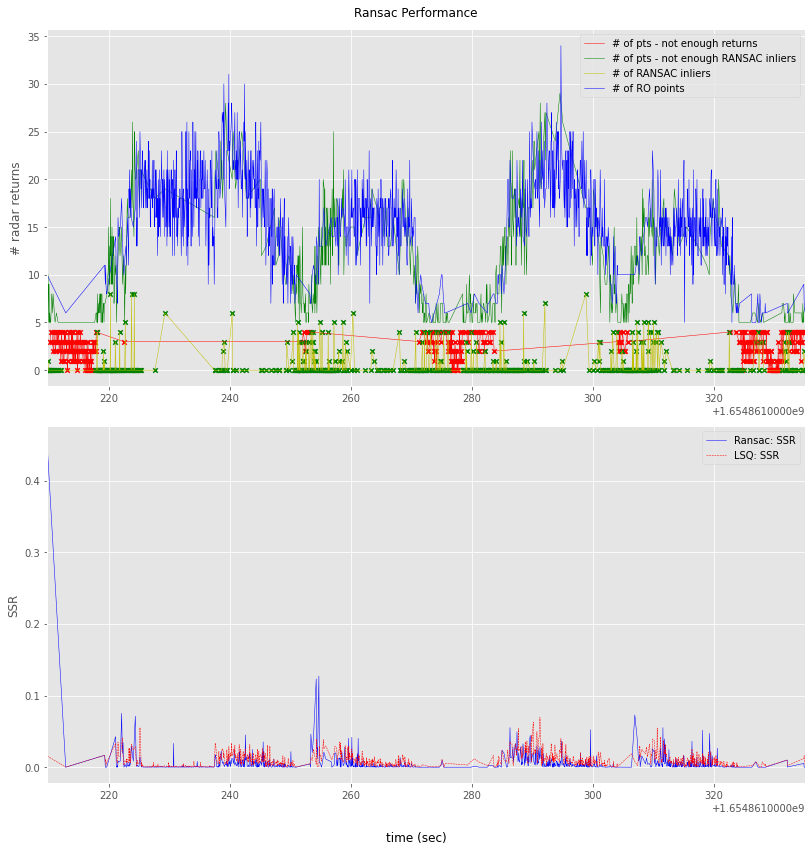

In [273]:
# visualize velocity
fig, axs = plt.subplots(2)

axs[0].plot(t_pts, num_pts, 'r-', linewidth=.5, label="# of pts - not enough returns")
axs[0].plot(t_inliers, num_pts_incl_inliers, 'g-', linewidth=.5, label="# of pts - not enough RANSAC inliers")
axs[0].plot(t_inliers, num_inliers, 'y-', linewidth=.5, label="# of RANSAC inliers")
axs[0].plot(t_ro, num_pts_ro, 'b-', linewidth=.5, label="# of RO points")
axs[0].scatter(t_pts, num_pts, s=20, marker='x', color='red')
axs[0].scatter(t_inliers, num_inliers, s=20, marker='x', color='green')
axs[1].plot(t_ro, ransac_ssr_ro, 'b-', linewidth=.5, label="Ransac: SSR")
axs[1].plot(t_ro, lsq_ssr_ro, 'r--', linewidth=.5, label="LSQ: SSR")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()

fig.supxlabel("time (sec)")
axs[0].set_ylabel("# radar returns")
axs[1].set_ylabel("SSR")
for i in range(2):
    axs[i].set_xlim([t_ro[0], t_ro[-1]])
plt.suptitle("Ransac Performance")
plt.show()

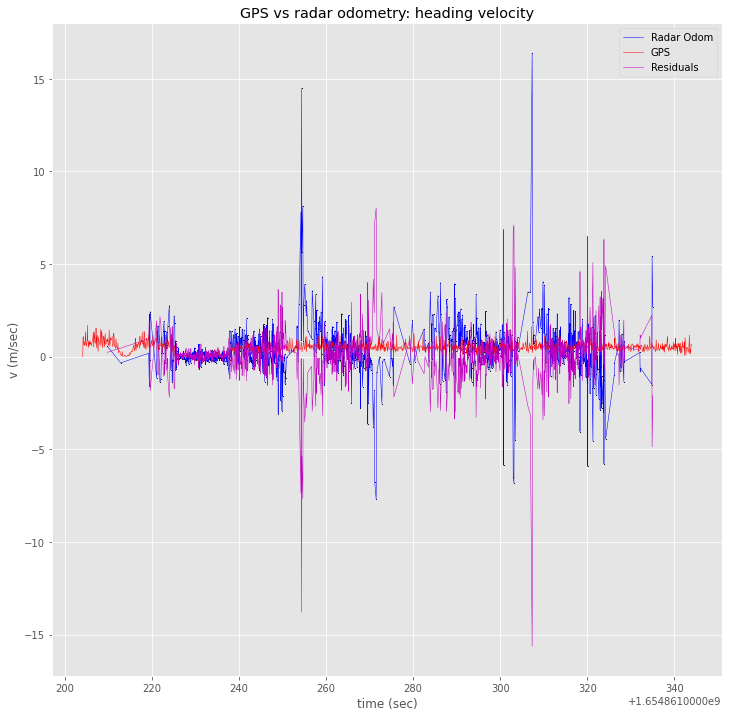

In [274]:
fig, ax = plt.subplots()

# radar odometry heading velocity
ax.plot(t_ro, v_ro, 'b-', linewidth=.5, label="Radar Odom")
ax.scatter(t_ro, v_ro, s=0.3, color='black')

# gps heading velocity
# ax.plot(t_gps_twist, gps_heading_vel, 'g-', linewidth=0.5, label="GPS : v")
ax.plot(t_gps_pos, gps_hv, 'r-', linewidth=0.5, label="GPS")

# residuals
# ax.plot(t_ro, vel_resids, 'y-', linewidth=.5, label="v residuals")
ax.plot(t_ro, v_res, 'm-', linewidth=.5, label="Residuals")

ax.set_xlabel("time (sec)")
ax.set_ylabel("v (m/sec)")
ax.set_title("GPS vs radar odometry: heading velocity")
ax.legend()
plt.show()

## Orientation

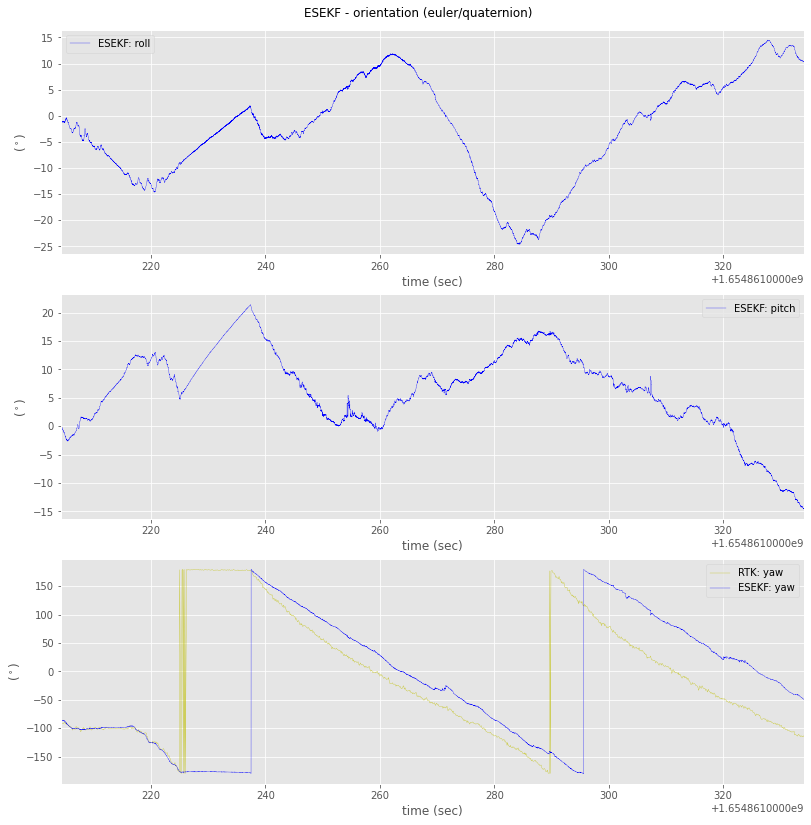

In [275]:
# visualize orientation  
## transform state orientation to euler
state_e = np.empty((0,3), float)
for x in q0:
    y = [x[3], x[0], x[1], x[2]]
    e = quat2euler(y)
    state_e = np.append(state_e, [e.flatten()], axis=0)
    
fig, axs = plt.subplots(3)

axs[2].plot(t_gps_heading, np.rad2deg(gps_heading), 'y-', linewidth=0.3, label="RTK: yaw")

axs[0].plot(t_state0, np.rad2deg(state_e[:,0]), 'b-', linewidth=0.3, label="ESEKF: roll")
axs[1].plot(t_state0, np.rad2deg(state_e[:,1]), 'b-', linewidth=0.3, label="ESEKF: pitch")
axs[2].plot(t_state0, np.rad2deg(state_e[:,2]), 'b-', linewidth=0.3, label="ESEKF: yaw")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[0].set_xlabel("time (sec)")
axs[0].set_ylabel("($^\circ$)")
axs[1].legend()
axs[1].set_xlabel("time (sec)")
axs[1].set_ylabel("($^\circ$)")
axs[2].legend()
axs[2].set_xlabel("time (sec)")
axs[2].set_ylabel("($^\circ$)")

for i in range(3):
    axs[i].set_xlim([t_gps_heading[0], t_gps_heading[-1]])

plt.xlabel("time (sec)")
plt.suptitle("ESEKF - orientation (euler/quaternion)")
plt.show()

## Position

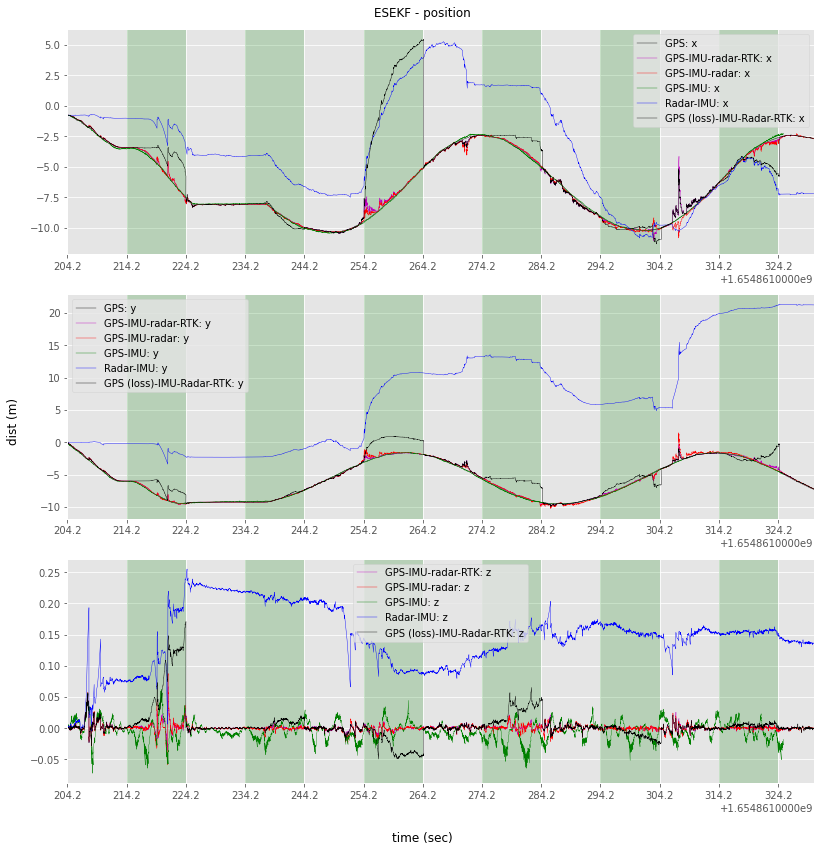

In [276]:
# visualize position
fig, axs = plt.subplots(3)

# ros2 data

axs[0].plot(t_gps_pos, gps_pos[:, 0], 'k-', linewidth=.4, label="GPS: x")
axs[1].plot(t_gps_pos, gps_pos[:, 1], 'k-', linewidth=.4, label="GPS: y")


axs[0].plot(t_state_ori, pori[:,0], 'm-', linewidth=.4, label="GPS-IMU-radar-RTK: x")
axs[1].plot(t_state_ori, pori[:,1], 'm-', linewidth=.4, label="GPS-IMU-radar-RTK: y")
axs[2].plot(t_state_ori, pori[:,2], 'm-', linewidth=.4, label="GPS-IMU-radar-RTK: z")

axs[0].plot(t_state0, p0[:,0], 'r-', linewidth=.4, label="GPS-IMU-radar: x")
axs[1].plot(t_state0, p0[:,1], 'r-', linewidth=.4, label="GPS-IMU-radar: y")
axs[2].plot(t_state0, p0[:,2], 'r-', linewidth=.4, label="GPS-IMU-radar: z")

axs[0].plot(t_state1, p1[:,0], 'g-', linewidth=.4, label="GPS-IMU: x")
axs[1].plot(t_state1, p1[:,1], 'g-', linewidth=.4, label="GPS-IMU: y")
axs[2].plot(t_state1, p1[:,2], 'g-', linewidth=.4, label="GPS-IMU: z")

axs[0].plot(t_state2, p2[:,0], 'b-', linewidth=.4, label="Radar-IMU: x")
axs[1].plot(t_state2, p2[:,1], 'b-', linewidth=.4, label="Radar-IMU: y")
axs[2].plot(t_state2, p2[:,2], 'b-', linewidth=.4, label="Radar-IMU: z")

axs[0].plot(t_stateall, pall[:,0], 'k-', linewidth=.4, label="GPS (loss)-IMU-Radar-RTK: x")
axs[1].plot(t_stateall, pall[:,1], 'k-', linewidth=.4, label="GPS (loss)-IMU-Radar-RTK: y")
axs[2].plot(t_stateall, pall[:,2], 'k-', linewidth=.4, label="GPS (loss)-IMU-Radar-RTK: z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

for i in range(3):
    axs[i].set_xlim([t_statel[0], t_statel[-1]])
    axs[i].set_xticks(np.arange(min(t_statel), max(t_statel), 10))

t0 = t_statel[0]
for j in range(3):
    for i in range(1,14,2):
        axs[j].axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='green', alpha=0.2)
    
fig.supxlabel("time (sec)")
fig.supylabel("dist (m)")
fig.suptitle("ESEKF - position")
plt.show()

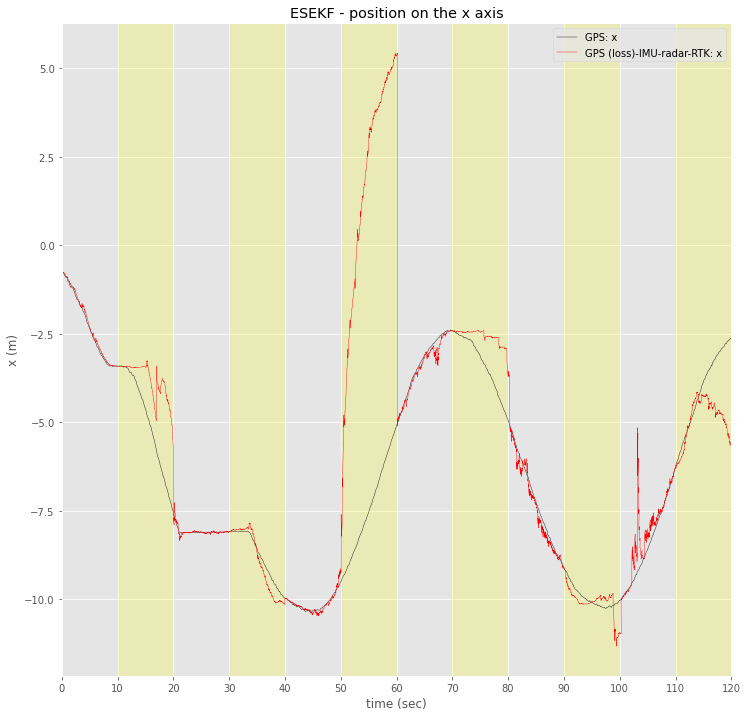

In [277]:
# visualize position
fig, ax = plt.subplots(figsize=(12, 12))
# ros2 data

ax.plot(tt_gps_pos, gps_pos[:, 0], 'k-', linewidth=.4, label="GPS: x")
ax.plot(tt_stateall, pall[:,0], 'r-', linewidth=.4, label="GPS (loss)-IMU-radar-RTK: x")

t0 = tt_stateall[0]
for i in range(1,14,2):
    ax.axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='yellow', alpha=0.2)
        
ax.set_xlim([tt_gps_pos[0], 120])
ax.set_xticks(np.arange(min(tt_state2), max(tt_state2), 10))
ax.legend()

ax.set_xlabel("time (sec)")
ax.set_ylabel("x (m)")
ax.set_title("ESEKF - position on the x axis")
plt.show()

## Velocity

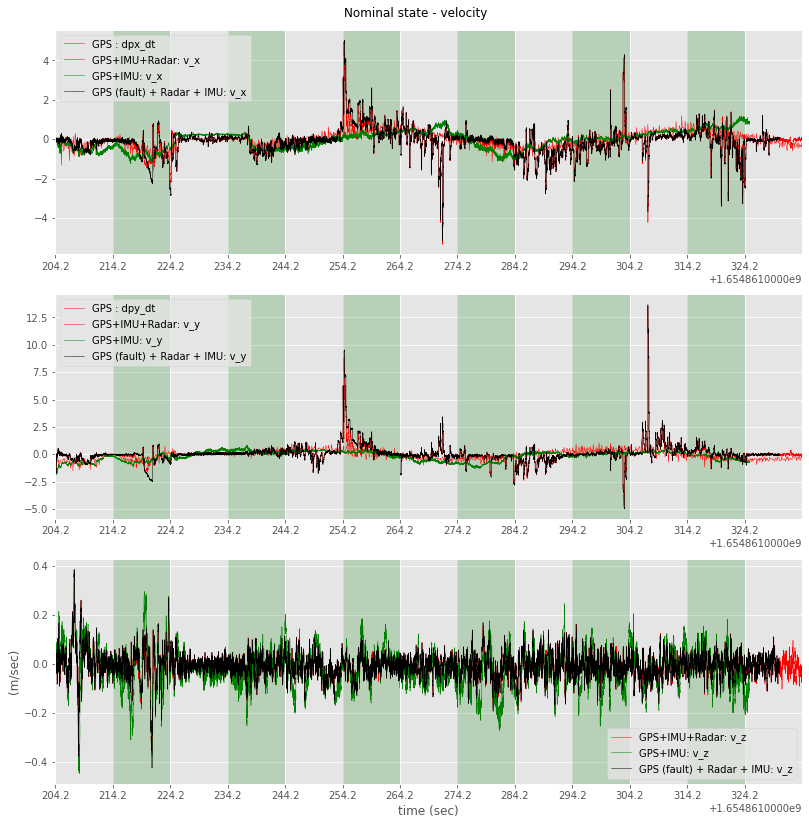

In [278]:
# visualize velocity
fig, axs = plt.subplots(3)

# axs[0].plot(t_gps_twist, vx_gps, 'm-', linewidth=0.5, label="GPS : v_x")
# axs[1].plot(t_gps_twist, vy_gps, 'm-', linewidth=0.5, label="GPS : v_y")

axs[0].plot(t_gps_pos, gps_dp[:,0], 'r-', linewidth=0.5, label="GPS : dpx_dt")
axs[1].plot(t_gps_pos, gps_dp[:,1], 'r-', linewidth=0.5, label="GPS : dpy_dt")

axs[0].plot(t_state0, v0[:,0], 'r-', linewidth=.5, label="GPS+IMU+Radar: v_x")
axs[1].plot(t_state0, v0[:,1], 'r-', linewidth=.5, label="GPS+IMU+Radar: v_y")
axs[2].plot(t_state0, v0[:,2], 'r-', linewidth=.5, label="GPS+IMU+Radar: v_z")

axs[0].plot(t_state1, v1[:,0], 'g-', linewidth=.5, label="GPS+IMU: v_x")
axs[1].plot(t_state1, v1[:,1], 'g-', linewidth=.5, label="GPS+IMU: v_y")
axs[2].plot(t_state1, v1[:,2], 'g-', linewidth=.5, label="GPS+IMU: v_z")

# axs[0].plot(t_state2, v2[:,0], 'b-', linewidth=.5, label="Radar + IMU: v_x")
# axs[1].plot(t_state2, v2[:,1], 'b-', linewidth=.5, label="Radar + IMU: v_y")
# axs[2].plot(t_state2, v2[:,2], 'b-', linewidth=.5, label="Radar + IMU: v_z")

axs[0].plot(t_statel, vl[:,0], 'k-', linewidth=.5, label="GPS (fault) + Radar + IMU: v_x")
axs[1].plot(t_statel, vl[:,1], 'k-', linewidth=.5, label="GPS (fault) + Radar + IMU: v_y")
axs[2].plot(t_statel, vl[:,2], 'k-', linewidth=.5, label="GPS (fault) + Radar + IMU: v_z")



plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

for i in range(3):
    axs[i].set_xlim([t_gps_twist[0], t_gps_twist[-1]])
    axs[i].set_xticks(np.arange(min(t_statel), max(t_statel), 10))

t0 = t_statel[0]
for j in range(3):
    for i in range(1,14,2):
        axs[j].axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='green', alpha=0.2)
        
plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Nominal state - velocity")
plt.show()

## Trajectory

In [279]:
# we are missing the very first measurement because it was not published
temp = np.array([-0.755, 0]).reshape((1,2))
gps_pos1 = np.vstack((temp, gps_pos))

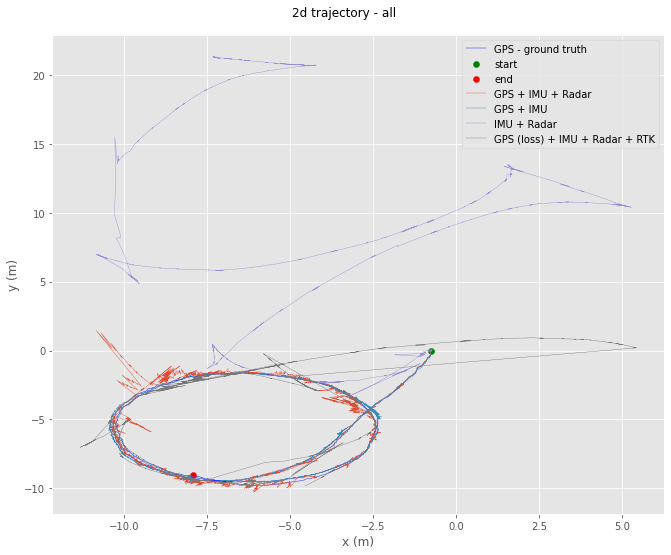

In [280]:
# visualize position
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(gps_pos1[:,0], gps_pos1[:,1], color="blue", linewidth=.4, label="GPS - ground truth")
ax.scatter(gps_pos1[0,0], gps_pos1[0,1], color="green", label="start")
ax.scatter(gps_pos1[-1,0], gps_pos1[-1,1], color="red", label="end")

ax.plot(p0[:,0], p0[:,1], linewidth=.4, label="GPS + IMU + Radar")
ax.plot(p1[:,0], p1[:,1], linewidth=.4, label="GPS + IMU")
ax.plot(p2[:,0], p2[:,1], linewidth=.4, label="IMU + Radar")

ax.plot(pall[:,0], pall[:,1], linewidth=.4, label="GPS (loss) + IMU + Radar + RTK")
# ax.plot(pf[:,0], pf[:,1], linewidth=.4, label="GPS (fault) + IMU + Radar")


plt.tight_layout(pad=4, w_pad=0, h_pad=1)
ax.legend()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.suptitle("2d trajectory - all")
plt.show()

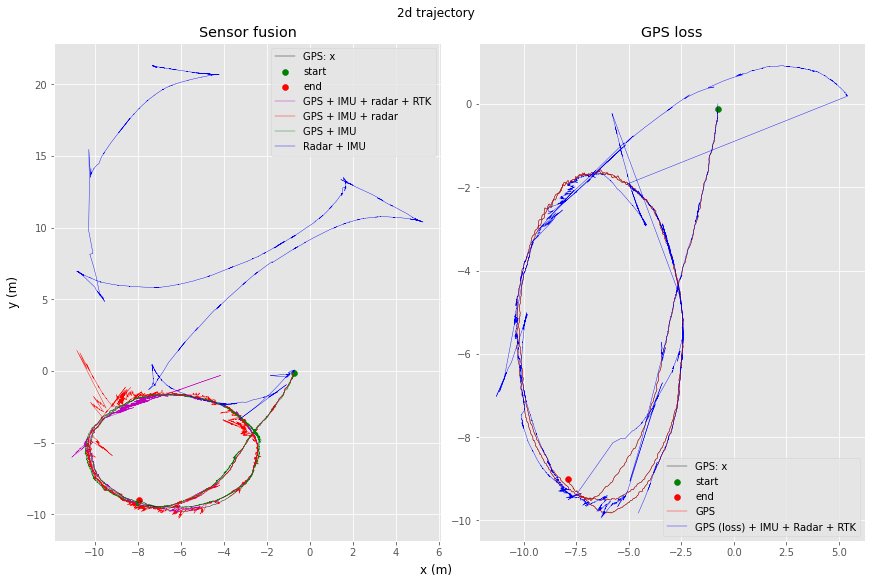

In [281]:
# visualize position
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8),
                        constrained_layout=True)

# add ground truth
for ax in [ax1, ax2]:
    ax.plot(gps_pos[:,0], gps_pos[:,1], 'k-', linewidth=.4, label="GPS: x")
    ax.scatter(gps_pos[0,0], gps_pos[0,1], color="green", label="start")
    ax.scatter(gps_pos[-1,0], gps_pos[-1,1], color="red", label="end")

# sensor fusion
ax1.plot(pori[:,0], pori[:,1], "-m", linewidth=.4, label="GPS + IMU + radar + RTK")
ax1.plot(p0[:,0], p0[:,1], "-r", linewidth=.4, label="GPS + IMU + radar")
ax1.plot(p1[:,0], p1[:,1], "-g", linewidth=.4, label="GPS + IMU")
ax1.plot(p2[:,0], p2[:,1], "-b", linewidth=.4, label="Radar + IMU")

ax2.plot(gps_pos[:,0], gps_pos[:,1], "-r", linewidth=.4, label="GPS")
ax2.plot(pall[:,0], pall[:,1], "-b", linewidth=.4, label="GPS (loss) + IMU + Radar + RTK")

        
for ax in [ax1, ax2]:
    ax.legend()

ax1.set_title("Sensor fusion")
ax2.set_title("GPS loss")
        
fig.supxlabel("x (m)")
fig.supylabel("y (m)")
fig.suptitle("2d trajectory")
plt.show()

# END